<a href="https://colab.research.google.com/github/tomektomeknyc/machinelearning/blob/main/VARMA_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
!wget https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2023-07-19 19:34:05--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: ‘temperature.csv’

temperature.csv     100%[===================>]   3.89M  12.1MB/s    in 0.3s    

2023-07-19 19:34:06 (12.1 MB/s) - ‘temperature.csv’ saved [4075992/4075992]



In [4]:
df = pd.read_csv('temperature.csv')

In [5]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [6]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [7]:
df['Date'] = df.apply(parse_date, axis=1)

In [8]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [9]:

# keep only columns we want
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [10]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

In [11]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [16]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

KeyError: ignored

In [17]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [18]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']


KeyError: ignored

In [19]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [20]:
joined = auckland.join(stockholm, how='outer') # has some missing data

In [21]:
joined.shape

(3155, 2)

In [22]:

joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [23]:

joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [24]:
joined_part.interpolate(inplace=True)


In [25]:
joined_part.isna().sum() # now all 0

AucklandTemp     0
StockholmTemp    0
dtype: int64

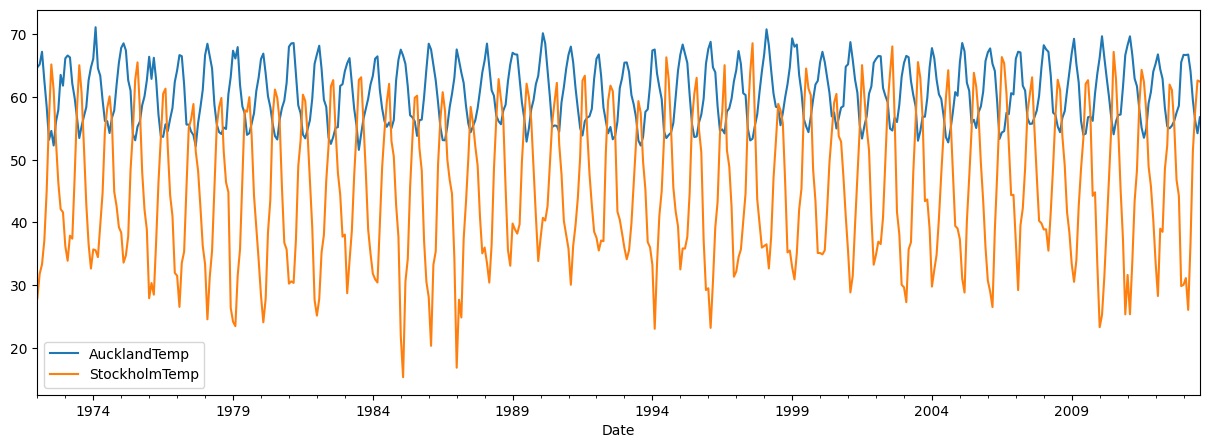

In [26]:
joined_part.plot(figsize=(15, 5));

In [27]:

Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [28]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
    train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [29]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(
    train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])


In [30]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [31]:
# put them back in original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']


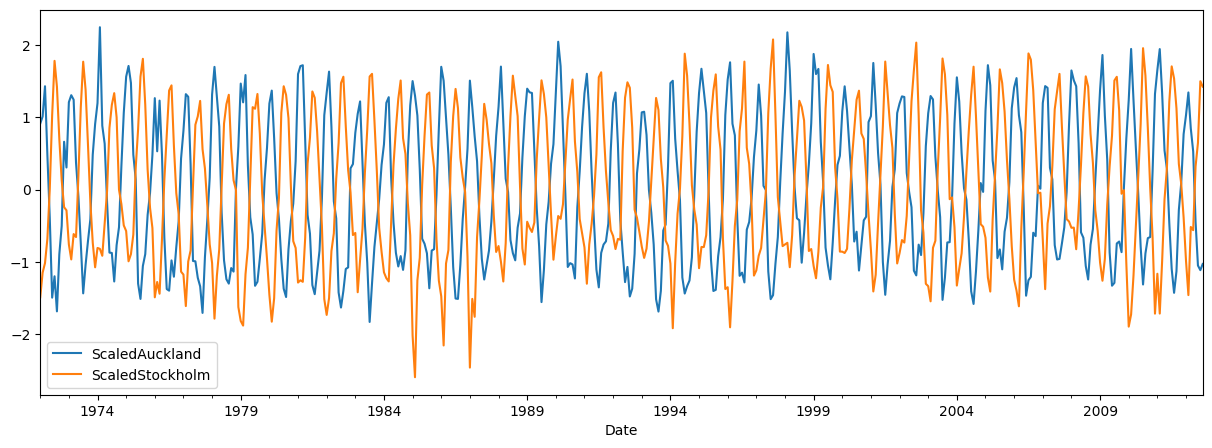

In [32]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(15, 5));

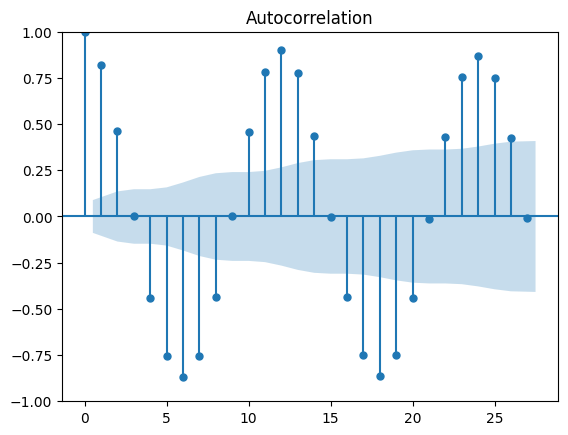

In [33]:
plot_acf(train['ScaledAuckland']);

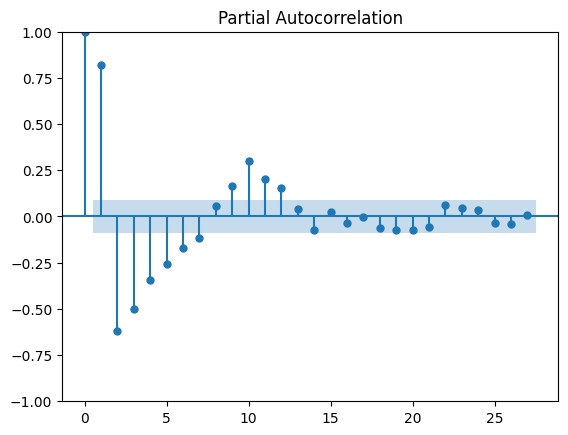

In [34]:
plot_pacf(train['ScaledAuckland']);

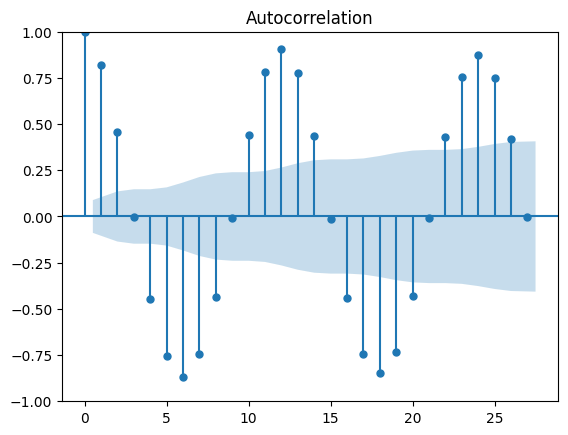

In [35]:
plot_acf(train['ScaledStockholm']);

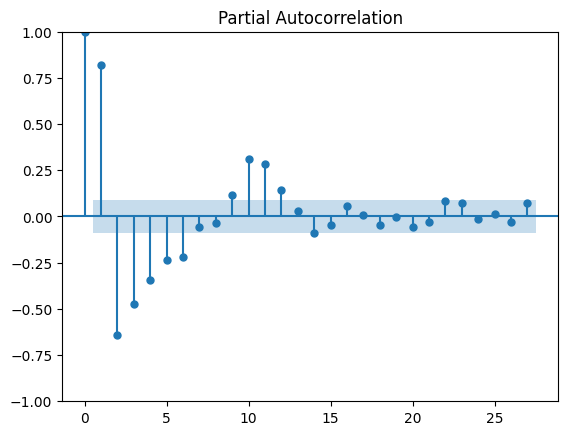

In [36]:
plot_pacf(train['ScaledStockholm']);

In [37]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:04:09.704165


In [38]:
fcast = res.get_forecast(Ntest)

In [39]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.008915
1972-02-01    0.835911
1972-03-01    0.717825
1972-04-01    0.818590
1972-05-01   -0.082818
                ...   
2012-04-01    0.513167
2012-05-01   -0.293116
2012-06-01   -1.064043
2012-07-01   -1.329765
2012-08-01   -1.065518
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [40]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast.predicted_mean['ScaledAuckland']

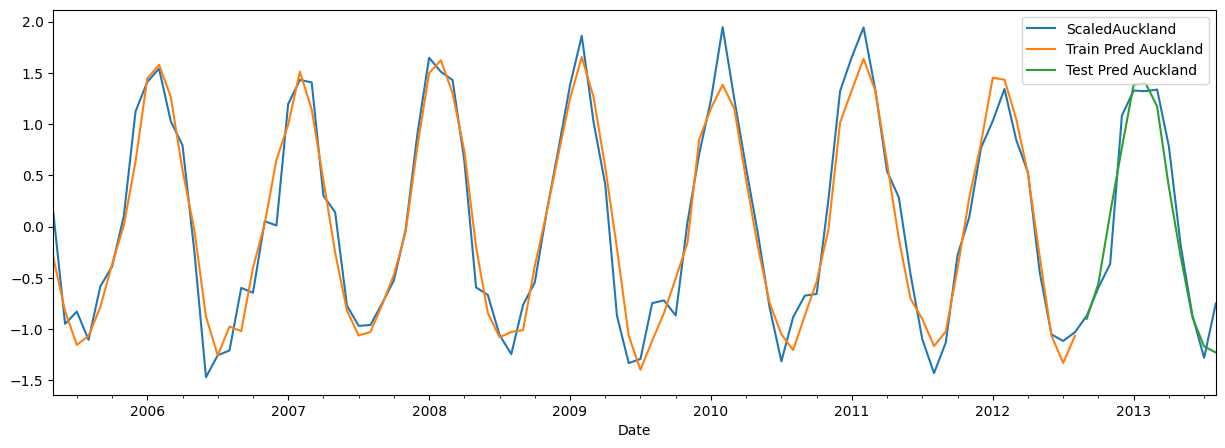

In [41]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [42]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast.predicted_mean['ScaledStockholm']

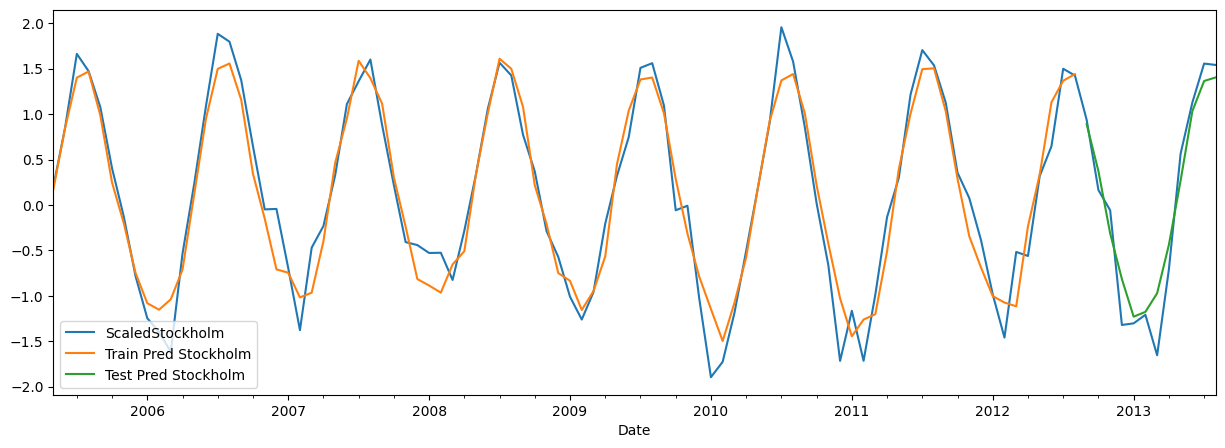

In [43]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));


In [44]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9295007431235751
Auckland Test R^2: 0.9291941168492315


In [45]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9247020765505378
Stockholm Test R^2: 0.9310538802475459


In [48]:
#VAR

In [49]:
model = VAR(train[cols])

In [50]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [51]:
lag_order_results.selected_orders


{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [52]:
results = model.fit(maxlags=15, ic='aic')

In [53]:
lag_order = results.k_ar

In [54]:
prior = train.iloc[-lag_order:][cols].to_numpy() # why need this?
fcast = results.forecast(prior, Ntest)

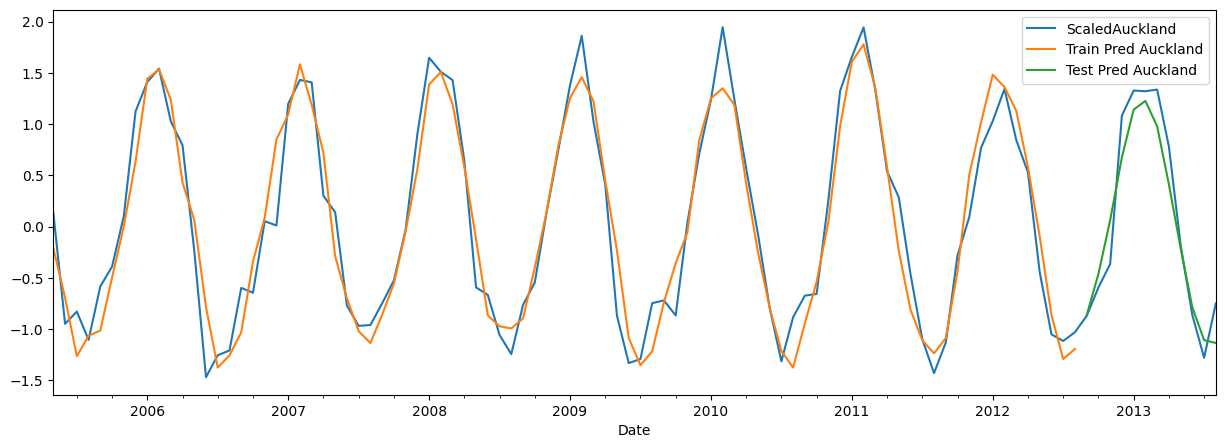

In [55]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

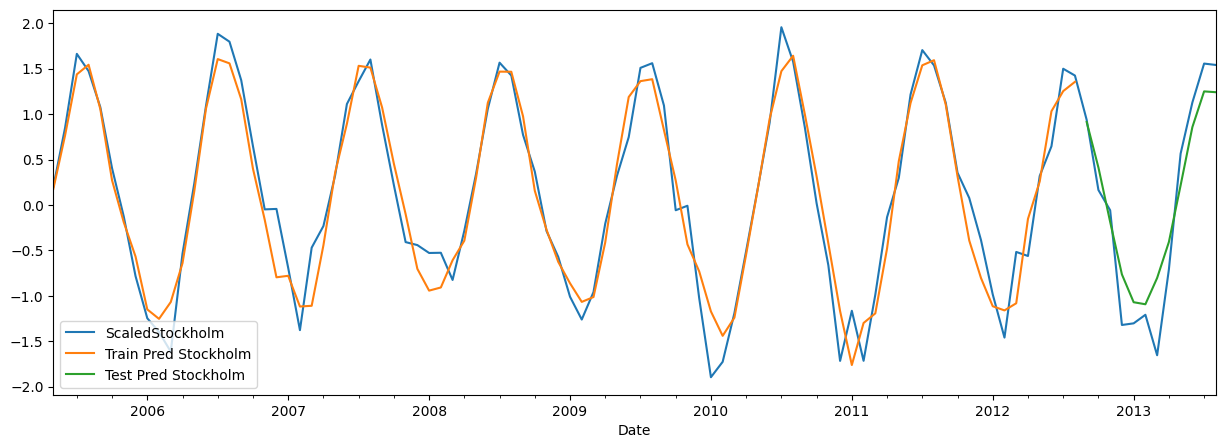

In [56]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));


In [57]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340893


In [58]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204873


In [59]:
##ARIMA Baseline


In [60]:

from statsmodels.tsa.arima.model import ARIMA

In [61]:
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213761721503834
ScaledAuckland Test R^2: 0.9380708604821664


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledStockholm Train R^2: 0.9207187533492664
ScaledStockholm Test R^2: 0.9482034765595303
